In [60]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot, CoV_plot, mapped_samples_pair_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range, convert_array_range
from utils.set_seed import setup_seed

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

src/username/data/NSC/data/dataset_L0_exp_set_0.h5


## Slice sampling plot

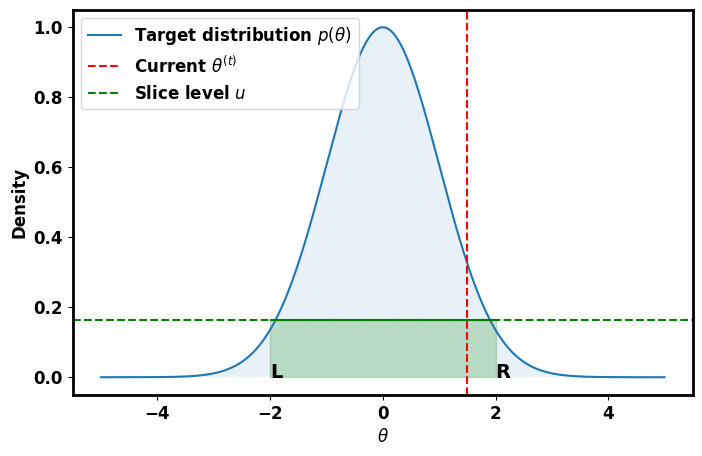

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Example target distribution function (replace with your actual function)
def p(x):
    return np.exp(-x**2 / 2)

# Domain and range
x = np.linspace(-5, 5, 1000)
y = p(x)

# Example slice parameters
x_current = 1.5
y_slice = p(x_current) * 0.5
slice_interval = (-2, 2)

fig = plt.figure(figsize=(8, 5))
# Plot the distribution
plt.plot(x, y, label=r'Target distribution $p(\theta)$')
plt.fill_between(x, y, alpha=0.1)

# Plot the vertical slice
plt.axvline(x_current, color='red', linestyle='--', label=r'Current $\theta^{(t)}$')
plt.axhline(y_slice, color='green', linestyle='--', label='Slice level $u$')

# Plot the horizontal slice
plt.hlines(y_slice, slice_interval[0], slice_interval[1], color='green')
plt.fill_betweenx([y_slice, 0], slice_interval[0], slice_interval[1], color='green', alpha=0.2)


plt.text(-2, 0, r'L', fontsize=14)
plt.text(2, 0, r'R', fontsize=14)

plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend()
# plt.title('Slice Sampling Illustration')
plt.savefig('slice_sampling_diagram.png')
plt.show()

fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
save_fig = fig_dir / 'slicing-sampling.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

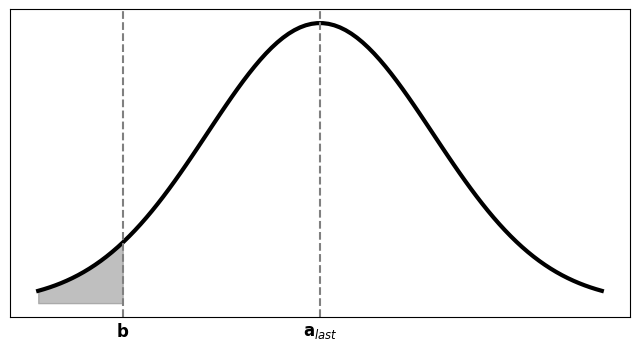

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

plt.rc('font', size=20, weight='bold')          # controls default text sizes

# Generate some data
np.random.seed(0)
data = np.random.randn(1000)

std=2
# Calculate the PDF over a range of values
x = np.linspace(-5, 5, 100)
y = norm.pdf(x, 0, std)  # mean=0, std=1

# Create a new figure and set the facecolor to none (transparent)
fig = plt.figure(facecolor='none', figsize=(8, 4))
ax = fig.add_subplot(111)

# Plot the Gaussian distribution curve
ax.plot(x, y, 'k', linewidth=3)

b=-3.5
# Draw a vertical line at x = 1
ax.axvline(x=b, color='gray', linestyle='--')
ax.axvline(x=0, color='gray', linestyle='--')

# Fill the area under the curve for x > 1
# x_fill = np.linspace(b, 5, 100)
x_fill = np.linspace(-5, b, 100)
y_fill = norm.pdf(x_fill, 0, std)
ax.fill_between(x_fill, y_fill, color='gray', alpha=0.5)

# draw a bi-directional arrow from x=0 to x=1

# annotate the sigma values
# ax.annotate('$\sqrt{\mathbf{var}_{last}}$', xy=(0.5, 0.1), xytext=(0, 0.12),)
# ax.arrow(0, 0.1, 1.9, 0, head_width=0.02, head_length=0.5, fc='k', ec='k')


# Remove the background
ax.set_facecolor('none')
# remove the ticks
ax.tick_params(axis='both', which='both', length=0)
# set x=0 with x tick label a
ax.set_xticks([0, b])
ax.set_xticklabels(["$\mathbf{a}_{last}$", 'b'])

# Hide the axis labels and grid
ax.set_yticklabels([])
ax.grid(False)

# Show the plot
plt.show()

## load data for CoV

In [91]:
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
data = torch.load(valid_data_dir)
x_o = data["x_o"]
seqC_o = data["seqC_o"]
params = data["params"]
probR = data["probR"]
chR = data["chR"]
prior_labels = data["prior_labels"]
normed_limits = data["normed_limits"]
designed_limits = data["designed_limits"]
step = 7
nT = 28
num_params = 4
C_idx = 0
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S

# map 3, 5, 7, 9, 11, 13, 15
chosen_dur_list = np.array([3, 9, 15])
chosen_dur_idx = ((chosen_dur_list - 3) / 2).astype(int)

x_o_chosen_dur = x_o[chosen_dur_idx].reshape(-1, 15)
x_o_all = x_o.reshape(-1, 15)
print(f"==>> x_o_chosen_dur.shape: {x_o_chosen_dur.shape}")
print(f"==>> x_o_all.shape: {x_o_all.shape}")

==>> x_o_chosen_dur.shape: torch.Size([6300, 15])
==>> x_o_all.shape: torch.Size([14700, 15])


In [94]:
pipeline_version = "nle-p2"
# train_id = "L0-nle-p2-cnn"
# exp_id = "L0-nle-p2-cnn-datav2-small-batch-newLoss"
# log_exp_id = "nle-p2-cnn-datav2-newLoss"
pipeline_version = "nle-p3"
train_id = "L0-nle-p3-cnn"
exp_id = "L0-nle-p3-cnn-newLoss"
log_exp_id = "nle-p3-cnn-newLoss"
use_chosen_dur = 0
T_idx = 0
iid_batch_size_theta = 100

# pipeline_version = "nle-p3"
# train_id = "L0-nle-p3-cnn"
# exp_id = "L0-nle-p3-cnn-newLoss-tmp-2"
# log_exp_id = "nle-p3-cnn-newLoss"
# use_chosen_dur = 0
# T_idx = 0
# iid_batch_size_theta = 100

## load training events

In [99]:
# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / train_id / exp_id
(
    wall_time,
    step_nums,
    learning_rates,
    loss_train,
    loss_valid,
) = get_train_valid_lr(log_dir, use_loss=True)

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['learning_rates'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## training curve

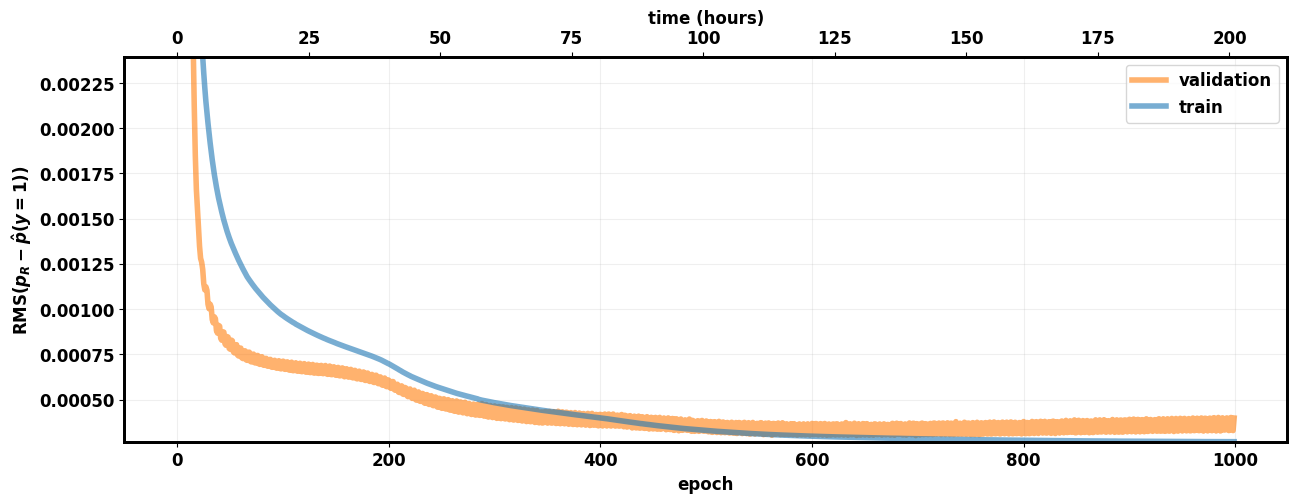

In [101]:
all_loss = np.concatenate([loss_train, loss_valid])
upper = np.percentile(all_loss, 98)
lower = np.min(all_loss)

# %% ========== plot training curves
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(step_nums, loss_valid, label="validation", alpha=0.6, ms=0.2, color=colors[1], lw=4)
ax.plot(step_nums, loss_train, label="train", alpha=0.6, ms=0.2, color=colors[0], lw=4)
ax.set_ylim(lower, upper)
ax.set_xlabel("epoch")
ax.set_ylabel("RMS$(p_R-\hat{p}(y=1))$")
ax.grid(alpha=0.2)
ax.legend()

ax1 = ax.twiny()
ax1.plot(
    (np.array(wall_time) - wall_time[0]) / 60 / 60,
    max(loss_valid) * np.ones_like(loss_valid),
    "-",
    alpha=0,
)
ax1.set_xlabel("time (hours)")

save_fig = fig_dir / 'nle' / f'{log_exp_id}-training-curve.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [103]:
np.sqrt(min(loss_valid))

0.017346058085960774

## check the trained model

In [20]:
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / train_id / exp_id

config_nle, model_path_nle = load_stored_config(exp_dir=log_dir)

if "p2" in pipeline_version:
    from train_nle.train_p2 import Solver
if "p3" in pipeline_version:
    from train_nle.train_p3 import Solver

solver_nle = Solver(config_nle, store_config=False)
solver_nle.init_inference(
    iid_batch_size_x=config_nle.posterior.MCMC_iid_batch_size_x,  #!
    # iid_batch_size_theta=config_nle.posterior.MCMC_iid_batch_size_theta,  # + info: 10000 MCMC init, other time 1
    iid_batch_size_theta=iid_batch_size_theta,  # + info: 10000 MCMC init, other time 1
    sum_writer=False,
)

# get the trained network
_, _, density_estimator, train_dataset, valid_dataset = solver_nle.inference.prepare_dataset_network(
    config_nle,
    continue_from_checkpoint=model_path_nle,
    device="cuda" if torch.cuda.is_available() and config_nle.gpu else "cpu",
    print_info=True,
    inference_mode=True,
    low_batch=5,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train_nle/logs/L0-nle-p3-cnn/L0-nle-p3-cnn-newLoss/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]
prepare train, val dataset and dataloader
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets
start loading data into MEM ... 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ==================================================
[dataset info]
total # samples: 132300000
chosen sets ['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
--------------------------------------------------
shapes:
[seqC] shape: torch.Size([18, 7, 3, 700, 15])
[theta] shape: torch.Size([18, 500, 4])
[probR] shape: torch.Size([18, 7, 3, 700, 500, 1])
-----------------------

In [50]:
# check estimator's output using prepared validation dataset
D_idx = 0
M_idx = 0
S_idx = 10
T_idx = 12

x_o_test = torch.cat((x_o[D_idx, M_idx, S_idx, :][1:], torch.tensor([1])))
probR_test = probR[D_idx, M_idx, S_idx, T_idx, :]
params_test = params[T_idx, :]
x_o_test = x_o_test.reshape(1, -1).to(dtype=torch.float32)
params_test = convert_samples_range(params_test, designed_limits, normed_limits)
params_test = params_test.reshape(1, -1).to(dtype=torch.float32)
print(f"==>> x_o_test: {x_o_test}")
print(f"==>> params_test: {params_test}")

log_prob = density_estimator.log_prob(
    x = x_o_test.to(solver_nle.device),
    theta = params_test.to(solver_nle.device),
)
prob = torch.exp(log_prob)
print()
print(f"predict: {prob.item()}\nactual: {probR_test.item()}\nerror: {prob.item() - probR_test.item()}")

==>> x_o_test: tensor([[0.6000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
==>> params_test: tensor([[0.7000, 0.8333, 0.5556, 0.5714]])

predict: 0.4560089707374573
actual: 0.4355455250515772
error: 0.0204634456858801


In [32]:
data_idx = 1000
x_o_test = valid_dataset[data_idx][0][:-1].reshape(1, -1)
probR_test = valid_dataset[data_idx][0][-1].reshape(1, -1)
params_test = valid_dataset[data_idx][1].reshape(1, -1)
print(f"==>> x_o_test: {x_o_test}")
print(f"==>> params_test: {params_test}")
print(f"==>> probR_test: {probR_test}")

log_prob = density_estimator.log_prob(
    x = x_o_test.to(solver_nle.device),
    theta = params_test.to(solver_nle.device),
)
prob = torch.exp(log_prob)
print(f"==>> predict: {prob}")

==>> x_o_test: tensor([[0.4000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
==>> params_test: tensor([[0.7219, 0.3854, 0.7279, 0.1047]])
==>> probR_test: tensor([[0.2012]])
==>> predict: tensor([0.1762], device='cuda:0', grad_fn=<ExpBackward0>)


## check posterior

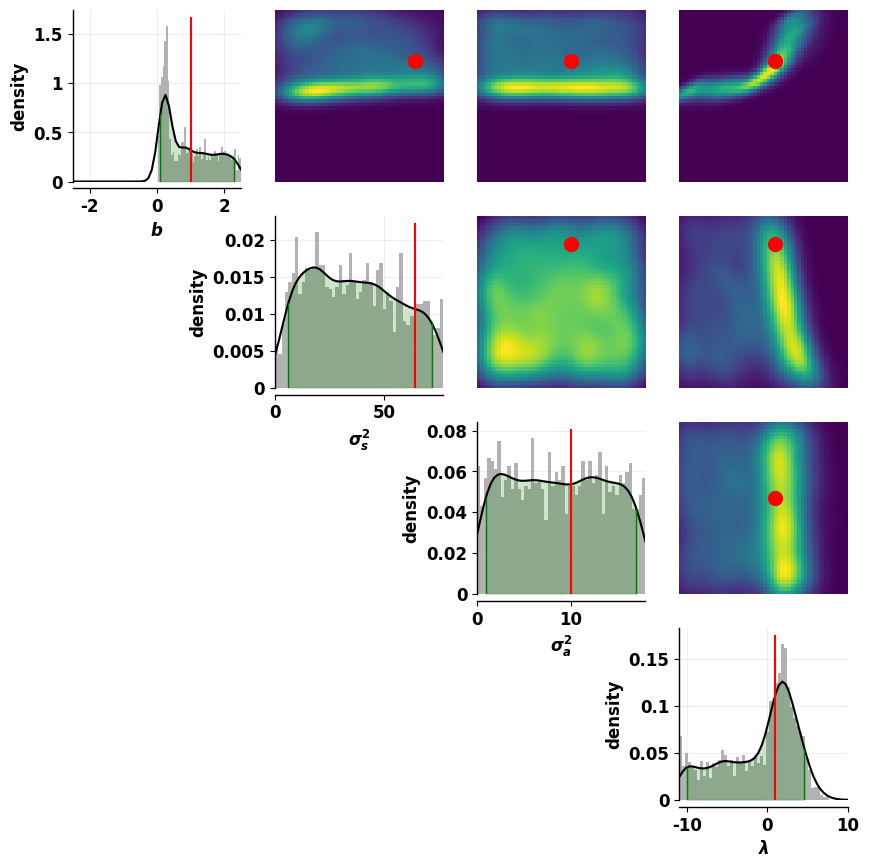

In [49]:
# load np array
params_idx = 12
samples_dir = f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_all_dur_2k_T{params_idx}.npy"
samples = np.load(samples_dir)
true_theta = params[params_idx, :]
true_theta = convert_samples_range(true_theta, designed_limits, normed_limits)

fig, ax, samples = mapped_samples_pair_plot(
    samples,
    true_theta=true_theta,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-one-posterior.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)


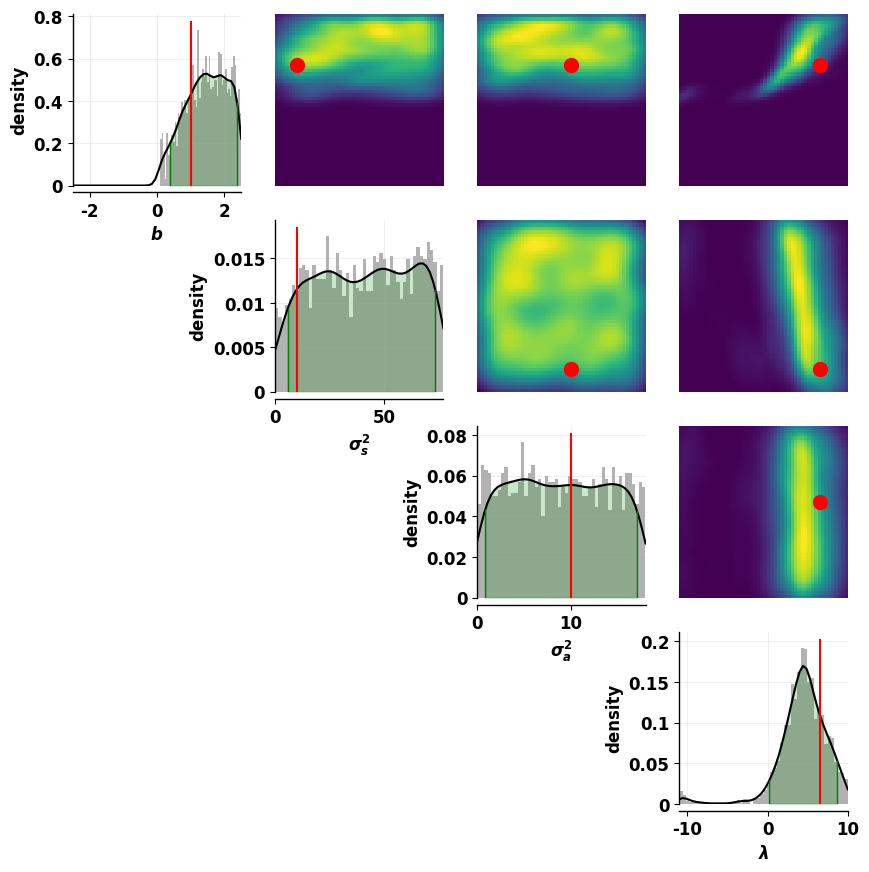

In [57]:
# load np array
params_idx = 26
samples_dir = f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_all_dur_2k_T{params_idx}.npy"
samples = np.load(samples_dir)
true_theta = params[params_idx, :]
true_theta = convert_samples_range(true_theta, designed_limits, normed_limits)

fig, ax, samples = mapped_samples_pair_plot(
    samples,
    true_theta=true_theta,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-one-posterior-2.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## check posterior CoV - change of variables

In [37]:
all_samples = np.zeros((4, step - 2, 2_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
# for T in [0]:
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue
    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1
    
    # == prepare the data for inference
    # = convert the theta to the normed range
    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    samples_dir = adapt_path(f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_all_dur_2k_T{T}.npy")
    samples = np.load(samples_dir)
    
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_631831/1672349721.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()


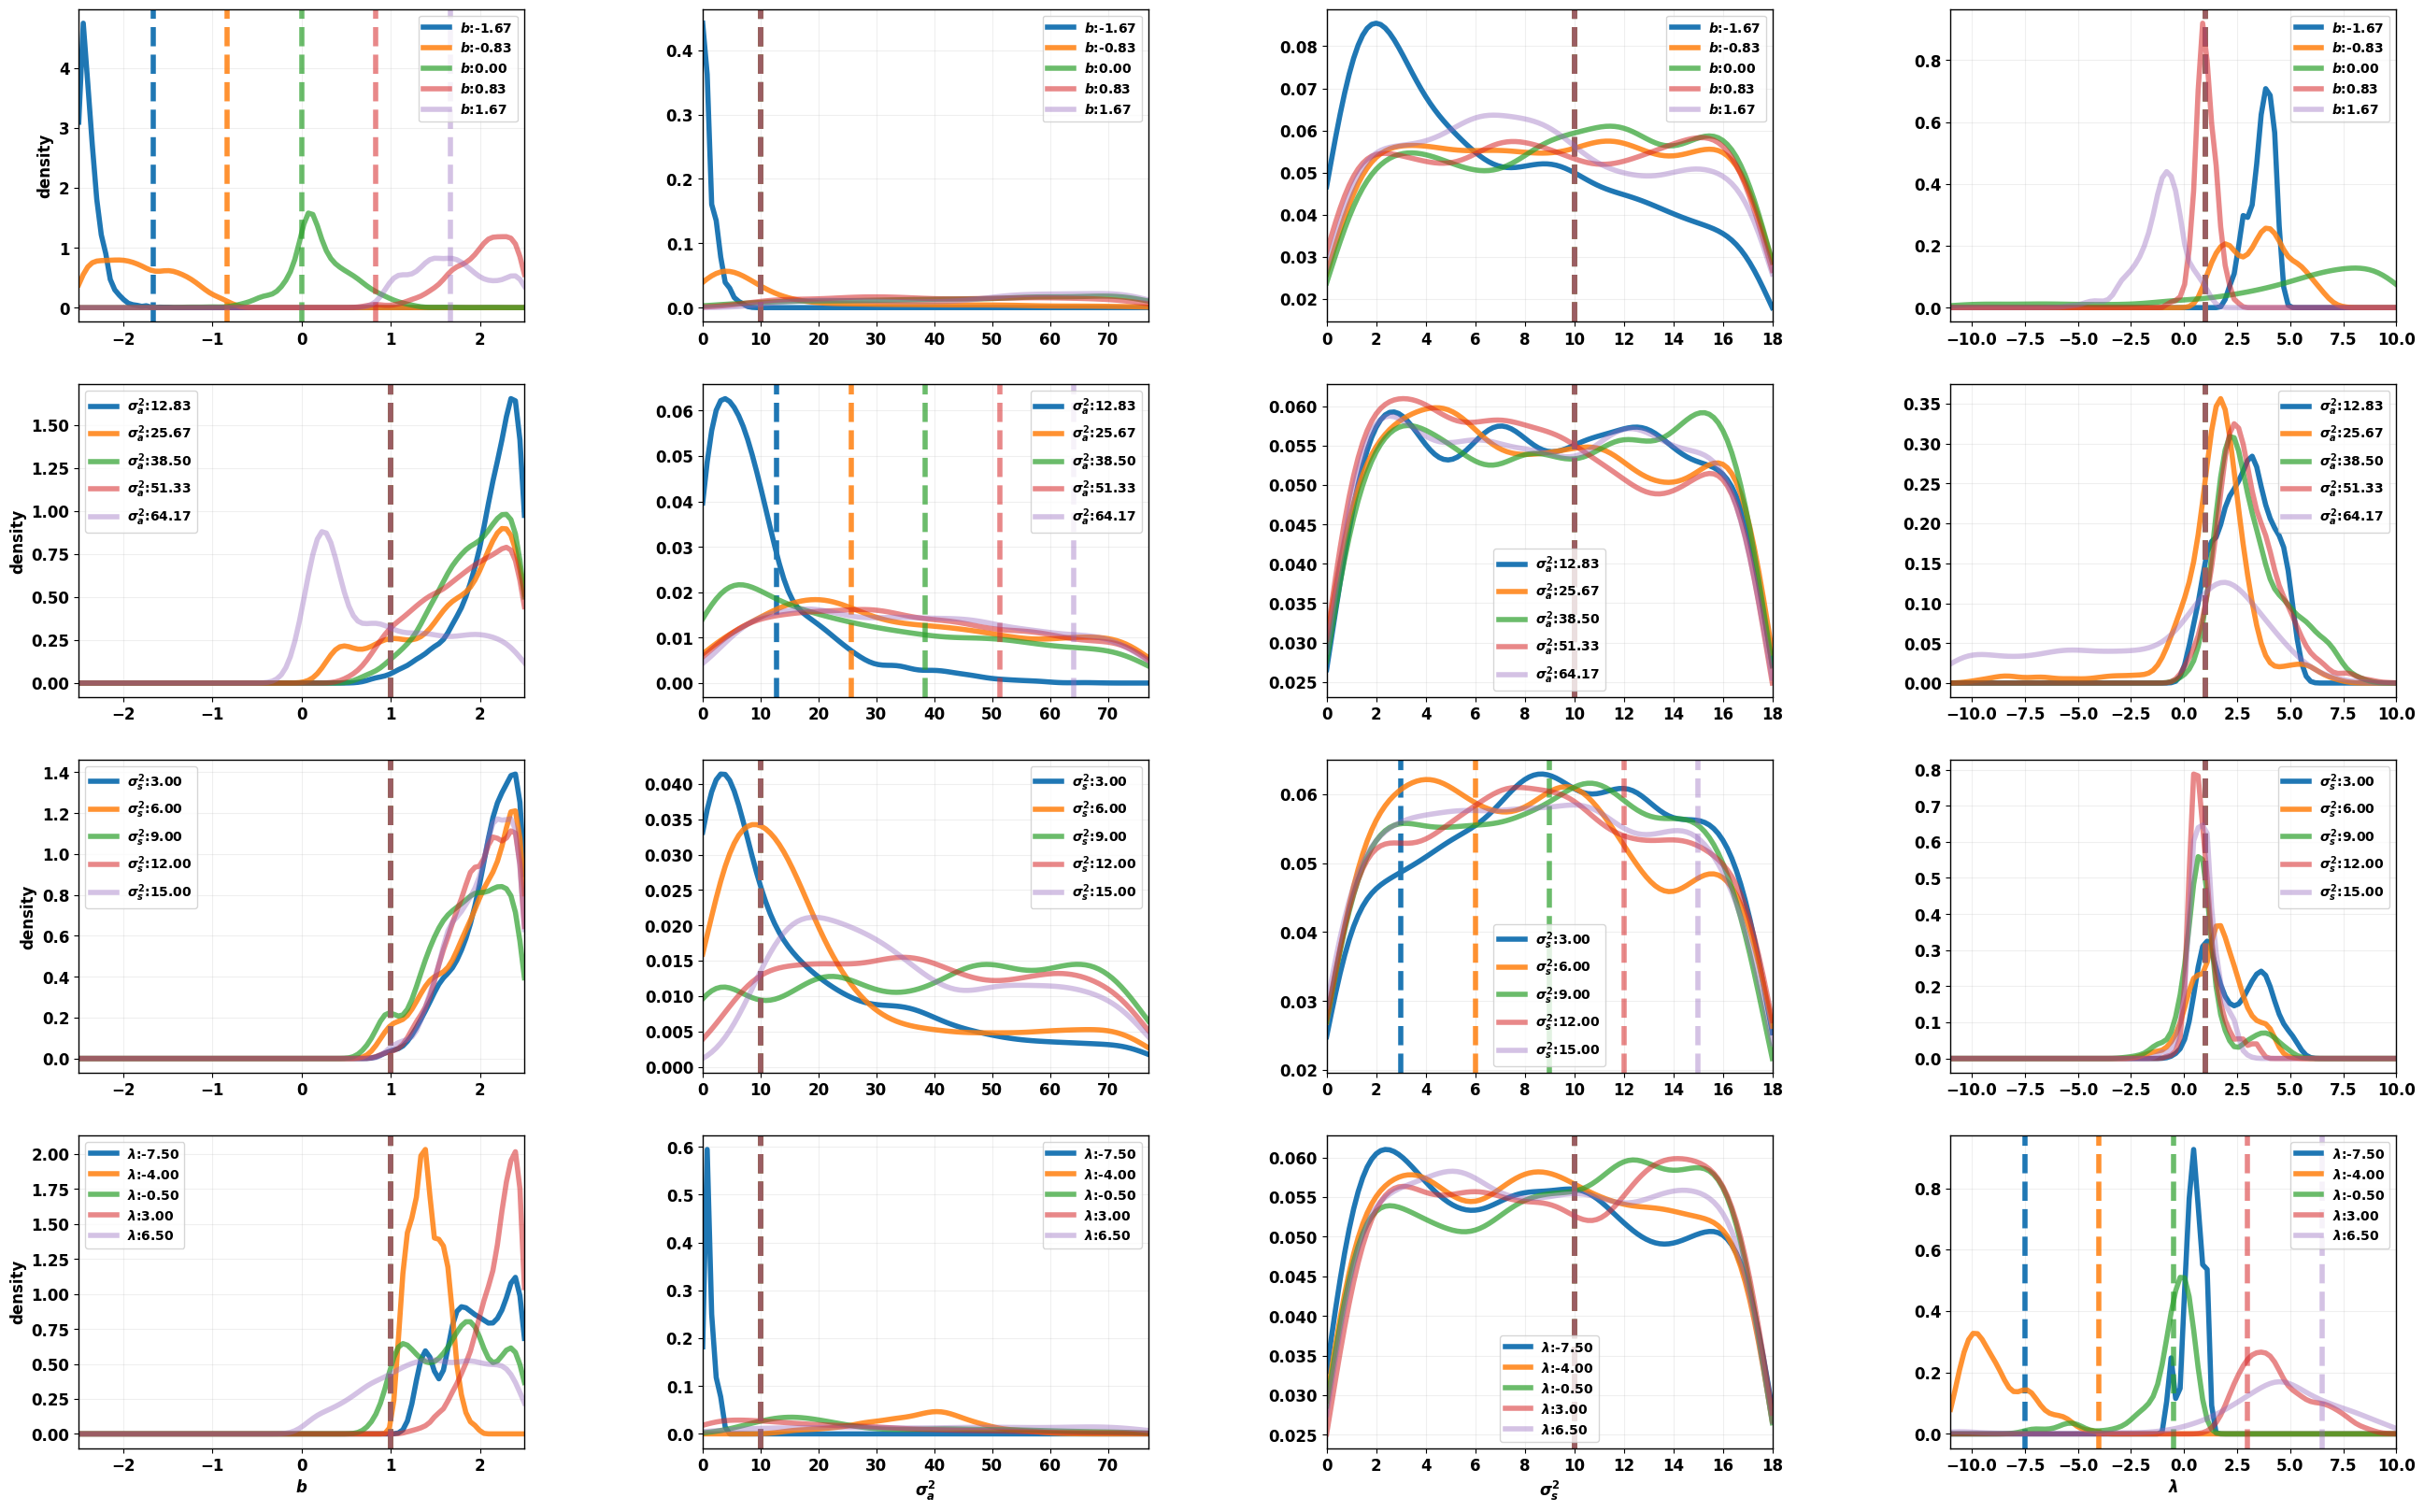

In [38]:
fig = CoV_plot(
    all_samples_dr,
    all_thetas_dr,
    num_params,
    designed_limits,
    prior_labels,
    colors,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-CoV-chosen_dur-2k.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [test acc] check acc

In [58]:
from utils.inference import estimate_theta_from_post_samples
from simulator.seqC_generator import seqC_generator
from simulator.DM_model import DM_model
model_name = 'B-G-L0S-O-N-'

In [60]:
dest_limits = designed_limits
theta_estimate = np.zeros((all_samples_dr.shape[0], all_samples_dr.shape[1], all_samples_dr.shape[-1]))
for i in range(all_samples_dr.shape[0]):
    for j in tqdm(range(all_samples_dr.shape[1])):
        theta_estimate[i, j, :] = estimate_theta_from_post_samples(dest_limits, all_samples_dr[i,j], mode="mode")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


In [62]:
all_thetas_dr.shape, theta_estimate.shape

(torch.Size([4, 5, 4]), (4, 5, 4))

In [63]:
all_thetas_dr[0:2,0:2], theta_estimate[0:2,0:2]

(tensor([[[-1.6667, 10.0000, 10.0000,  1.0000],
          [-0.8333, 10.0000, 10.0000,  1.0000]],
 
         [[ 1.0000, 12.8333, 10.0000,  1.0000],
          [ 1.0000, 25.6667, 10.0000,  1.0000]]]),
 array([[[-2.46198479,  0.30812325,  1.99519808,  3.85714286],
         [-2.06182473,  4.12885154, 11.36614646,  3.92436975]],
 
        [[ 2.37194878,  3.75910364,  2.67226891,  3.17647059],
         [ 2.26990796, 19.47338936,  4.42977191,  1.70588235]]]))

In [80]:
setup_seed(0)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC}")


--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [[[[0.  0.  0.4 0.  0.  0.  0.  0.  0.4 nan nan nan nan nan nan]]]]


In [81]:
probR_estimate = []
probR_true = []
for i in range(all_thetas_dr.shape[0]):
    for j in tqdm(range(all_thetas_dr.shape[1])):
        params=theta_estimate[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_estimate.append(probR)
        
        params=all_thetas_dr[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_true.append(probR)
        print(f"==>> true a[-1]: {a[-1]}, params: {params}, probR: {probR}")

100%|██████████| 5/5 [00:00<00:00, 670.30it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([-1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.6082143658517221
==>> true a[-1]: 0.17521343308796897, params: tensor([-0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.5597747953122932
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.0000, 10.0000, 10.0000,  1.0000]), probR: 0.5104225712691928
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.46091006195225603
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.4119969443373398


100%|██████████| 5/5 [00:00<00:00, 679.13it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 12.8333, 10.0000,  1.0000]), probR: 0.45675242308298025
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 25.6667, 10.0000,  1.0000]), probR: 0.46936613099889657
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 38.5000, 10.0000,  1.0000]), probR: 0.4749730239220712
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 51.3333, 10.0000,  1.0000]), probR: 0.47831970507841737
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 64.1667, 10.0000,  1.0000]), probR: 0.48060517287059257


100%|██████████| 5/5 [00:00<00:00, 738.25it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  3.0000,  1.0000]), probR: 0.4509890664831526
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  6.0000,  1.0000]), probR: 0.4510175379474972
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  9.0000,  1.0000]), probR: 0.4510459598509421
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 12.0000,  1.0000]), probR: 0.45107433233710525
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 15.0000,  1.0000]), probR: 0.45110265554902296


100%|██████████| 5/5 [00:00<00:00, 799.01it/s]

==>> true a[-1]: 0.033318518296069556, params: tensor([ 1.0000, 10.0000, 10.0000, -7.5000]), probR: 0.1208575901141683
==>> true a[-1]: 0.042286641732369325, params: tensor([ 1., 10., 10., -4.]), probR: 0.19771349996394916
==>> true a[-1]: 0.0841453581602924, params: tensor([ 1.0000, 10.0000, 10.0000, -0.5000]), probR: 0.36413271512381684
==>> true a[-1]: 0.7083681807922266, params: tensor([ 1., 10., 10.,  3.]), probR: 0.4969495370996644
==>> true a[-1]: 12.36849019663851, params: tensor([ 1.0000, 10.0000, 10.0000,  6.5000]), probR: 0.5039026285791276


In [82]:
probR_estimate, probR_true = np.array(probR_estimate), np.array(probR_true)
np.abs(probR_estimate - probR_true).mean()  

0.031015945678936657

In [83]:
# compute error for each parameter
probR_estimate_parts = probR_estimate.reshape(-1, 5)
probR_true_parts = probR_true.reshape(-1, 5)
error_parts = np.abs(probR_estimate_parts - probR_true_parts).mean(axis=1)

In [84]:
error_parts

array([0.01990927, 0.01681804, 0.0578622 , 0.02947427])

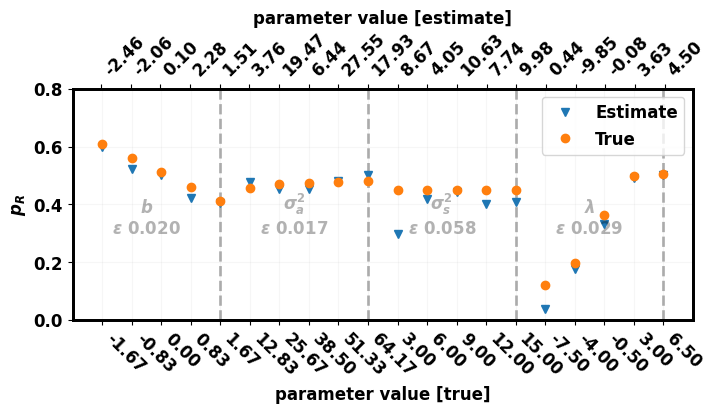

In [87]:
fig = plt.figure(figsize=(8,3))
plt.grid(alpha=0.1) 
plt.ylabel(f'$p_R$')
plt.xlabel('parameter value [true]')
plt.ylim([0,.8])
plt.xlim([-1, 20])
# plt vlines
plt.vlines(np.arange(4,20,5), 0, 1, colors='k', linestyles='--', lw=2, alpha=0.3)
# text align in center
plt.text(1.5, 0.3, f'$b$\n$\epsilon$ {error_parts[0]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(6.5, 0.3, f'$\sigma^2_a$\n$\epsilon$ {error_parts[1]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(11.5, 0.3, f'$\sigma^2_s$\n$\epsilon$ {error_parts[2]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(16.5, 0.3, f'$\lambda$\n$\epsilon$ {error_parts[3]:.3f}', fontsize=12, ha='center', alpha=0.3)

plt.plot(probR_estimate, 'v', label='Estimate', lw=2)
plt.plot(probR_true, 'o', label='True', lw=2)

# tick of x axis set as 0->20
xticks_label_array=np.array([all_thetas_dr[i, :, i].numpy() for i in range(4)]).reshape(-1)
# show 2 digits xtick label
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
plt.xticks(np.arange(20), xticks_label, rotation=-45, ha='left')

plt.legend()

# twinx
ax2 = plt.twiny()
# ax2.set_xlim(ax.get_xlim())
ax2.plot(np.arange(20), np.zeros(20), alpha=0)
xticks_label_array=np.array([theta_estimate[i, :, i] for i in range(4)]).reshape(-1)
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
ax2.set_xticks(np.arange(20), xticks_label, rotation=45, ha='left')
ax2.set_xlabel('parameter value [estimate]')

save_fig = fig_dir / 'nle' / f'{log_exp_id}-test-acc.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)